In [23]:
#pip install spotipy
#conda install opencv

GET YOUR OWN SPOTIFY WRAPPED!

In [24]:
import altair
import os
import io
import tkinter as tk
from PIL import Image, ImageTk
from urllib.request import HTTPError
import requests
import datetime
from urllib.parse import urlencode
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import base64
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from IPython import display
from base64 import b64decode
from math import pi
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import time
import requests
import spotipy
import spotipy.util as util
from io import BytesIO
from PIL import Image, ImageTk
from tkinter import Tk, Frame, Label
import webbrowser
from pprint import pprint
import pandas as pd
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import HTML,display
import altair as alt






In [25]:
# Itunes API

import requests
import webbrowser

class Media:

    def __init__(self, title="No Title", author="No Author", release_year="No Release Year", url="No URL", json=None):
        self.json = json
        if json is not None:
            #self.title = self.json['trackName'] #changed to collectionName, was collectioncensoredname. Now changed to trackName
            if self.json.get("trackName") is not None:
                self.title = self.json['trackName']
            else:
                self.title = self.json['collectionName']

            self.author = self.json['artistName']
            self.release_year = self.json['releaseDate'].split("-")[0] #need to  split

            if self.json.get("trackViewUrl") is not None:
                self.url = self.json['trackViewUrl']
            else:
                self.url = self.json['collectionViewUrl']
            #self.url = self.json['collectionViewUrl']
            #self.url = self.json['trackViewUrl'] #chnaged to trackviewurl, was collectionViewUrl

        else:
            self.title = title
            self.author = author
            self.release_year = release_year
            self.url = url

    def info(self):
        return f"{self.title} by {self.author} ({self.release_year})"

    def length(self):
        return 0


# Other classes, functions, etc. should go here

class Song(Media):
    def __init__(self, title="No Title", author="No Author", release_year="No Release Year", url="No URL", album="No Album", genre="No Genre", track_length=0, json=None):
        super().__init__(title, author, release_year, url, json)
        if json is not None:
            self.title = self.json['trackName'] 
            self.author = self.json['artistName']
            self.release_year = self.json['releaseDate'].split("-")[0] #need to  split
            self.url = self.json['trackViewUrl'] #wascollectionviewurl
            self.album = self.json['collectionName'] 
            self.genre = self.json['primaryGenreName']
            self.track_length = int(self.json['trackTimeMillis'])
        else:
            self.album = album
            self.genre = genre
            self.track_length = track_length

    def info(self):
        return f"{self.title} by {self.author} ({self.release_year}) [{self.genre}]"

    def length(self):
        round_l = round(self.track_length * 0.001)
        return round_l

class Movie(Media):
    def __init__(self, title="No Title", author="No Author", release_year="No Release Year", url="No URL", rating="No Rating", movie_length=0,json=None):
        super().__init__(title, author, release_year, url, json)
        if json is not None:
            self.title = self.json['trackName'] 
            self.author = self.json['artistName']
            self.release_year = self.json['releaseDate'].split("-")[0] #need to  split
            self.url = self.json['trackViewUrl']
            self.rating = self.json['contentAdvisoryRating']
            self.movie_length = self.json['trackTimeMillis']
        else:
            self.rating = rating
            self.movie_length = movie_length

    def info(self):
        return f"{self.title} by {self.author} ({self.release_year}) [{self.rating}]"

    def length(self):
        round_l = round(self.movie_length * 1.66667e-5)
        return round_l #rounding to the nearest minute

####################
###### Part 3 ######
####################

#Fetching data from iTunes

def song_format(song_list): 
    count = 1
    for song in song_list:
        print(count, song.info())
        count += 1
    return count

def movie_format(movie_list,c): 
    count = c
    for movie in movie_list:
        print(count, movie.info())
        count += 1
    return count

def other_format(other_list,c):
    count = c
    for other in other_list:
        print(count, other.info())
        count += 1
    return count

def final_format(song_list, movie_list, other_list): 
    #call song_format, movie_format, other_format
    print("SONGS")
    c = song_format(song_list)
    print("MOVIES")
    c = movie_format(movie_list,c)
    print("OTHER MEDIA")
    c = other_format(other_list,c)
    return c

In [26]:
#client_id = 'add your own'
#client_secret = 'add your own'
redirect = 'http://localhost:7777/callback'

In [27]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
        
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')
    
    def get_artist_albums(self, _id):
        headers = self.get_resource_header()
        BASE_URL = 'https://api.spotify.com/v1/'
        request = requests.get(BASE_URL + 'artists/' + _id + '/albums', headers=headers, params={'include_groups': 'album', 'limit': 50})
        a = request.json()
        return a
    
    def get_audio_features(self, _id):
        headers = self.get_resource_header()
        BASE_URL = 'https://api.spotify.com/v1/'
        #request = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers, params={'include_groups': 'album', 'limit': 50})
        request = requests.get(BASE_URL + 'audio-features/' + _id, headers=headers, params={'include_groups': 'album', 'limit': 50})
        a = request.json()
        return a

    def search(self, query, search_type='artist' ): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        data = urlencode({"q": query, "type": search_type.lower()})
        lookup_url = f"{endpoint}?{data}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()

    def get_album_img(self, _id):
        headers = self.get_resource_header()
        BASE_URL = 'https://api.spotify.com/v1/playlists'
        request = requests.get(BASE_URL + _id + '/images', headers=headers, params={'include_groups': 'album', 'limit': 50})
        a = request.json()
        return a



In [28]:
#spotifyAPI
spotify = SpotifyAPI(client_id, client_secret)

#spotipy
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect, scope='user-top-read'))


In [29]:
#spotify.search('shakira')

In [30]:
# FOR PERSONAL USER INFORMATION

def get_track_id(dict):
    track_ids = []
    for song in dict['items']:
        track_ids.append(song['id'])
    return track_ids #- it is a list of track ids

#Function to get users' top10 tracks

def get_final_top10(sp):
    all_top = sp.current_user_top_tracks()
    # Top 10 tracks
    top_tracks = sp.current_user_top_tracks(limit=10, offset=0, time_range='short_term')
    track_ids = get_track_id(top_tracks)

    song_info={'id':[],
           'album':[],
           'name':[],
           'artist':[],
           'explicit':[],
           'popularity':[],
           'album_img': []}

    for song_id in track_ids:
        # get song's meta data
        info = sp.track(song_id)
        # song id
        song_info['id'].append(song_id)
        # album name
        album=info['album']['name']
        song_info['album']+=[album]

        # song name
        song=info['name']
        song_info['name']+=[song]

        # artists name
        s = ', '
        artist=s.join([singer_name['name'] for singer_name in info['artists']])
        song_info['artist']+=[artist]

        # explicit: lyrics could be considered offensive or unsuitable for children
        explicit=info['explicit']
        song_info['explicit'].append(explicit)

        # song popularity
        popularity=info['popularity']
        song_info['popularity'].append(popularity)

        #album_image
        album_img = info['album']['images'][0]['url']
        song_info['album_img'].append(album_img)
    
    
    top_tracks_df = pd.DataFrame.from_dict(song_info)
    # Top track features : get track IDs -->  get audio info

    top_audio_features = sp.audio_features(song_info['id'])
    # change dictionary to dataframe
    top_tracks_features_df=pd.DataFrame.from_dict(top_audio_features)
    # Converting milliseconds to minutes
    top_tracks_features_df['duration_ms']=top_tracks_features_df['duration_ms']/60000
    
    #Final data frame : Tracks and features
    final_df=top_tracks_df.merge(top_tracks_features_df)


    return final_df




In [31]:
# When user inputs an artist name

#artist_name = spotify.search('drake')

# Get artist ID
def artist_id(dict):
    id = ''
    for i in dict['artists']['items']:
        id = i['id']
        return id


def get_artist_popularity(artist_id):
    info = sp.artist(artist_id)
    name = info['name']
    genres = [i for i in info['genres']]
    popularity_score = str(info['popularity'])
    print(name + " has a popularity score of " + popularity_score +"! The artists' typical genres are:")
    print(genres)





VISUALIZATIONS

RADAR CHART :
MEANING OF EACH OF THE ACOUSTIC FEATURES

In [32]:
# Visualization class

class visuals(object):
    def __init__(self, df ):
        self.df = df

    def display_tracks(df):
        print(df['name'])

    def show_radar_viz(df):
        radar_df = df[['danceability','energy','key','instrumentalness','liveness','valence','tempo']]
        min_max_scaler = MinMaxScaler()
        radar_df.loc[:]=min_max_scaler.fit_transform(radar_df.loc[:])
        # plot size
        fig=plt.figure(figsize=(12,8))

        # convert column names into a list
        categories=list(radar_df.columns)

        # number of categories
        N=len(categories)

        # create a list with the average of all features
        val=list(radar_df.mean())

        # repeat first value to close the circle
        # the plot is a circle, so we need to "complete the loop"
        # and append the start value to the end.
        val+=val[:1]

        # calculate angle for each category
        angles=[n/float(N)*2*pi for n in range(N)]
        angles+=angles[:1]

        # plot
        plt.polar(angles, val)
        plt.fill(angles,val,alpha=0.3)

        # plt.title('Discovery Weekly Songs Audio Features', size=35)

        plt.xticks(angles[:-1],categories, size=15)
        plt.yticks(color='grey',size=15)
        plt.show()


    def show_audio_relationships(df):
        #audio_rel_df = df[['name','artist','popularity','explicit','energy','instrumentalness']]

        a = df.plot.scatter(x = 'popularity', y = 'artist', c = 'green', s = 80)
        b = df.plot.scatter(x = 'energy', y = 'artist', c = 'blue', s = 80)
        c = df.plot.scatter(x = 'instrumentalness', y = 'name', c = 'red', s = 80)
        return a,b,c


    def show_audio_correlations(df):
        audio_correlations_df = df[['danceability','energy','key','instrumentalness','liveness']]
        corr = audio_correlations_df.corr()
        plt.figure(figsize=(12,8))
        sns.heatmap(corr, annot=True).set(title='Coorelations Between Track Features')
        plt.show()


    def show_album_cover(df):
        
        for i in df['album_img']:
            image = io.imread(i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image)
            plt.show()
        



In [33]:
#url = 'https://i.scdn.co/image/ab67616d0000b273f58c2d280edcb6931a108fbd'

# Load into browser 
#webbrowser.open(url)
#audio_rel_df = final_df[['name','artist','popularity','explicit','energy','instrumentalness']]

#audio_rel_df.plot.scatter(x = 'instrumentalness', y = 'name', c = 'red', s = 80)

a = get_final_top10(sp)
#a
#for i in a['album_img']:
    #print(i)
#visuals.show_audio_relationships(a)
#visuals.show_album_cover(a)

#visuals.display_tracks(a)
#visuals.show_audio_correlations(a)


Please provide  your clientID and client_secret. For more information, please refer to the README or refer to this link - https://developer.spotify.com/documentation/general/guides/authorization/app-settings/.


0             Won’t Let You Go
1    Not In Love (feat. LOWES)
2               The Difference
3       Posthumous Forgiveness
4      Pink Skies - Radio Edit
5         Everybody's Changing
6                Born At Night
7              The Crying Game
8                     Two High
9     I Wish (My Taylor Swift)
Name: name, dtype: object
None 
%


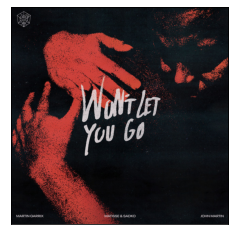

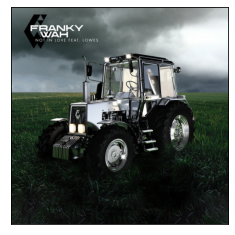

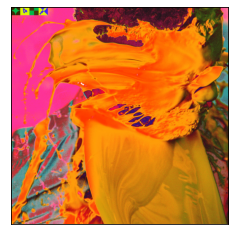

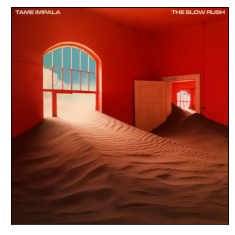

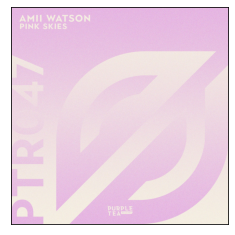

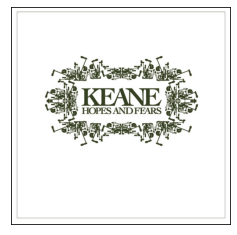

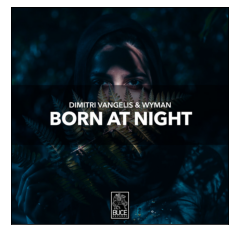

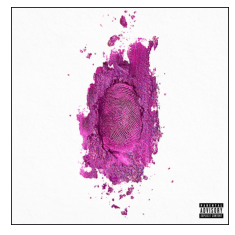

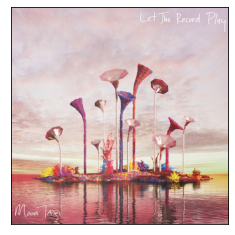

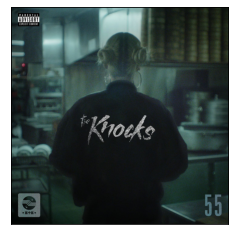

/Users/sereenkallerackal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


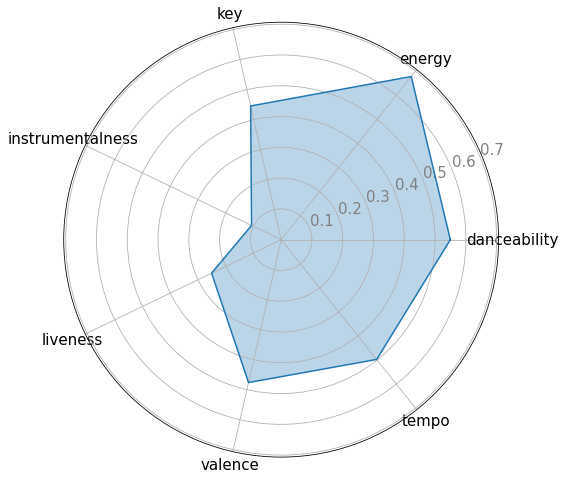

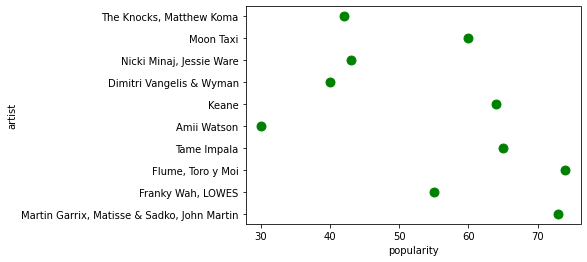

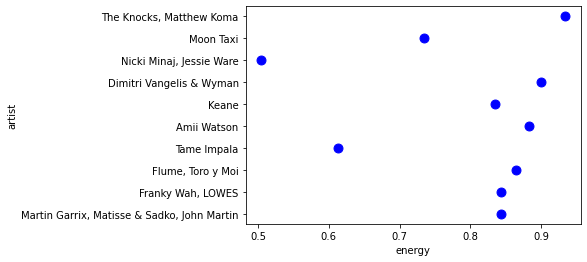

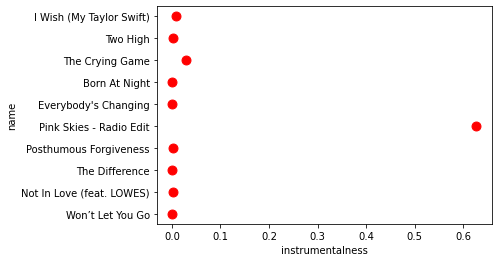

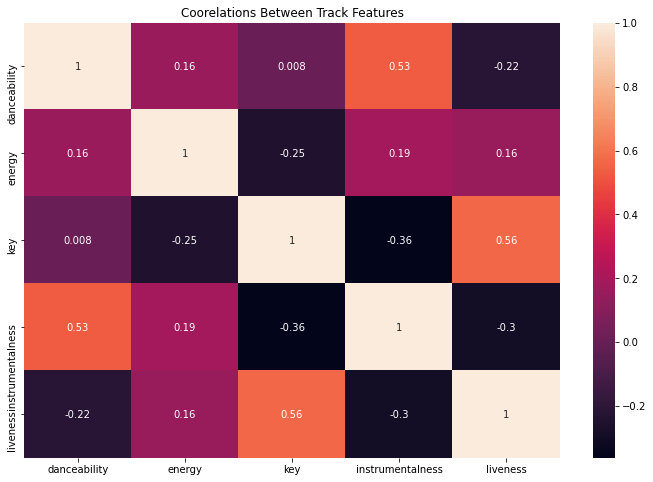

In [34]:
if __name__ == '__main__':

    while True:
        q1 = input("Do you have your spotify account details in hand? Type 'yes' to continue. If you don't have it yet, no worries. We can use the iTunes API to search for an artist. Please type 'exit' if you want to quit.")
        if q1.lower() == 'exit':
            break
        if q1.lower() == 'yes':
            print("Please provide  your clientID and client_secret. For more information, please refer to the README or refer to this link - https://developer.spotify.com/documentation/general/guides/authorization/app-settings/.")
            q2_client = input('Client ID:')
            q2_secret_client = input('Secret Client ID:')
            client_id = q2_client
            client_secret = q2_secret_client
            spotify = SpotifyAPI(client_id, client_secret)
            sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect, scope='user-top-read'))
            data = get_final_top10(sp)

            q3 = input("Would you like to see your top 10 tracks - yes or no? Please type 'exit' if you want to quit.")
            if q3.lower() == 'exit':
                break
            if q3.lower() == 'yes':
                display(HTML('<h1>Checkout your spotify wrapped! Here are your top 10 tracks!</h1>'))
                display1 = visuals.display_tracks(data)
                print(display1,'\n%')
                display(HTML('<h2>Your top Albums!</h2>'))
                visuals.show_album_cover(data)

                # Next question
                q4 = input("Would you like to analyze your musical inclinations - yes or no? Please type 'exit' if you want to quit.")
                if q4 == 'exit':
                    break
                if q4.lower() == 'yes':
                    display(HTML('<h2>Here are some visuals to see your musical inclinations!</h2>'))
                    visuals.show_radar_viz(data)
                    display(HTML('<h2> Your audio-features!</h2>'))
                    visuals.show_audio_relationships(data)
                    visuals.show_audio_correlations(data)
                    display(HTML('<h2>Hope this helped! Thank you!</h2>'))
                    break
                if q4.lower() == 'no':
                    print("No worries! Thanks for stopping by. See you another time!")
                    break
                break

            if q3.lower() == 'no':
                print("No worries! Thanks for stopping by. See you another time!")
                break
            else:
                print('Please enter a valid answer')
                continue
        if q1.lower() == 'no':
            print('No Worries, please give me an artist name!')
            q5 = input("Enter an artist name. For example, Drake, Bruno Mars, etc.")
            artist_name = spotify.search(q5)
            id = artist_id(artist_name)
            display(HTML('<h2>Here is some information on the artist!</h2>'))
            artist_popularity = get_artist_popularity(id)
            display(HTML('<h2>Here is some information from the itunes API</h2>'))
            base_url = 'https://itunes.apple.com/search?term="'
            song_kind = ['album', 'song']
            movie_kind = ['feature-movie']
            other_kind = []
            while True:
                song_list = []
                movie_list = []
                other_list = []
                
                if q5.isnumeric():
                    link = webbrowser.open(base_url+q5)
                    f" Launching {link} in web browser ..."
                else:
                    new_search = requests.get(base_url + q5)
                new_output = new_search.json()
                itunes_list = new_output['results']
                if not itunes_list:
                    print("Please try again")
                    continue

                #identify what kind it is 
                for item in itunes_list:
                    if item.get("kind") is not None:
                        kind = item['kind']
                        if kind in song_kind:
                            S = Song(json=item)
                            song_list.append(S)
                        elif kind in movie_kind:
                            M = Movie(json=item)
                            movie_list.append(M)
                        else:
                            O = Media(json=item)
                            other_list.append(O)
                    else:
                        #print("Does not exist")
                        # #instantiat Media with info here
                        O = Media(json=item)
                        other_list.append(O)


                final_format(song_list,movie_list,other_list)
                print(final_format)
                display(HTML('<h2>Hope this helped! Thank you!</h2>'))
                break
            break

        else:
            print('Please enter a valid number')
            continue
